# Обучение моделей

**Постановка задачи:**
> Дан новостной текст, содержащий в себе отдельно выделенную сущность "мнение". Даны также дополнительные признаки в виде субъекта и объекта мнения (могут отсутствовать). Необходимо определить, является ли мнение положительным (POS) или отрицательным (NEG) в данном контексте.

**Использованные модели:**

|Выбранная модель                  |  Способ токенизации      |   
|----------------------------------|--------------------------|
|LogReg                            |tfidf/word2vec/fasttext   |
| SVM                              | tfidf/word2vec/fasttext  |
| decision trees                   |tfidf/word2vec/fasttext   |
| LSTM                             | tfidf/word2vec/fasttext  |  
| ruBert-tiny                      |BERT   |   

**Критерии оценки качества:**
- F1-score 
- Интерпретируемость
- Быстродействие модели

## Базовые импорты

In [1]:
# остальное будем импортировать на момент непосредственного написания релевантного кода
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

## Поготовка данных

Поскольку мы планируем использовать три одинаковых метода токенизации для первых четырёх методов классицфикации, нам необходимо:
- Получить векторы TF-IDF
- Получить векторы Word2Vec
- Получить векторы FastText
- Сконкатенировать образовавшиеся признаки
- Разбить выборки на обучающую, валидационную и тестовую (80/10/10)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText

In [3]:
df = pd.read_csv("/kaggle/input/sentence-sence-dataset/sentences_with_full_features.csv")

In [4]:
df.sample(2)

,text,opinion,source,target,expression,polarity
3154,В прошлом году награды удостоились хирург из К...,"{'Source': [['NULL'], ['0:0']], 'Target': [['Д...",NaN,Денис Муквеге,награды удостоились,POS
1282,"Спустя день, 13 июля, Министерство обороны США...","{'Source': [['NULL'], ['0:0']], 'Target': [['N...",NaN,NaN,NaN,NONE


In [5]:
# оставляем только тексты, в которых есть чётко выраженная полярность
df.polarity.value_counts()

polarity
NEG     1730
POS     1174
NONE    1062
Name: count, dtype: int64

In [6]:
df = df.query("polarity!='NONE'").reset_index()

In [7]:
df.polarity.value_counts()

polarity
NEG    1730
POS    1174
Name: count, dtype: int64

In [8]:
df['text'] = df['text'].fillna("NONE")
df['expression'] = df['expression'].fillna("NONE")

In [9]:
df['combined'] = df['text'] + "|" + df['expression']

In [10]:
df.sample(3)

,index,text,opinion,source,target,expression,polarity,combined
1670,2445,1 июля 2019 года Хорошевский суд Москвы призна...,"{'Source': [['Мосгорсуд'], ['192:201']], 'Targ...",Мосгорсуд,Хорошевский суд Москвы,поддержал это решение,POS,1 июля 2019 года Хорошевский суд Москвы призна...
24,36,"Политологи заключили, что теперь Берлускони об...","{'Source': [['Берлускони'], ['33:43']], 'Targe...",Берлускони,кабинет министров,жесткой критикой,NEG,"Политологи заключили, что теперь Берлускони об..."
1902,2776,4 июля 2013 года представители армии Египта по...,"{'Source': [['армии Египта'], ['31:43']], 'Tar...",армии Египта,Мухаммеда Мурси,задержания,NEG,4 июля 2013 года представители армии Египта по...


### TF-IDF

In [11]:
# фильтруем слова, встречающиеся меньше чем в 30 текстах 
# учитывая что тексты зачастую одинаковые, т.к. в одном могло храниться сразу несколько мнений
tfidf_vectorizer = TfidfVectorizer(min_df=30) 
tfidf_vectors = tfidf_vectorizer.fit_transform(df['combined']).toarray()

In [12]:
# получаем 293 признака
tfidf_vectors.shape

(2904, 230)

### Word2Vec

In [13]:
from nltk.tokenize import word_tokenize
import nltk

In [14]:
# токенизируем текст
tokenized_text = [word_tokenize(text) for text in df['combined']]

In [15]:
# количество используемых в будущем фичей
tok_num = tfidf_vectors.shape[1]

In [16]:
# обучаем Word2Vec
# чтобы было "честно" -- размерность фичей зададим такую же, какая в tf-idf
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=tok_num, window=5, min_count=1, workers=4)

In [17]:
word2vec_vectors = np.array([
    np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(tok_num)], axis=0)
    for words in tokenized_text])

In [18]:
word2vec_vectors.shape

(2904, 230)

### FastText

In [19]:
# обучаем FastText
fasttext_model = FastText(sentences=tokenized_text, vector_size=tok_num, window=5, min_count=1, workers=4)

In [20]:
fasttext_vectors = np.array([
    np.mean([fasttext_model.wv[word] for word in words if word in fasttext_model.wv] or [np.zeros(tok_num)], axis=0)
    for words in tokenized_text])

In [21]:
fasttext_vectors.shape

(2904, 230)

### Разделение train/val/test

In [22]:
# конкатенируем признаки
features = np.hstack([tfidf_vectors, word2vec_vectors, fasttext_vectors])

In [23]:
features.shape

(2904, 690)

In [24]:
labels = df['polarity'].map({'POS': 1, 'NEG': 0}).values

In [25]:
# делим на обучающую, валидационную и тестовую выборки (80/15/5)
# стратификация по лейблам
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [26]:
print("Размерность обучающей выборки:", X_train.shape)
print("Размерность валидационной выборки:", X_val.shape)
print("Размерность тестовой выборки:", X_test.shape)

Размерность обучающей выборки: (2323, 690)
Размерность валидационной выборки: (435, 690)
Размерность тестовой выборки: (146, 690)


In [27]:
pd.DataFrame(y_test).value_counts()

0    87
1    59
Name: count, dtype: int64

### На всякий случай - делаем удобнее переменные индексаци

In [28]:
# рассчитываем индексы для каждой части
tfidf_end = tfidf_vectors.shape[1]
word2vec_start = tfidf_end
word2vec_end = word2vec_start + word2vec_vectors.shape[1]
fasttext_start = word2vec_end
fasttext_end = fasttext_start + fasttext_vectors.shape[1]

# проверяем
print("TF-IDF: от 0 до", tfidf_end)
print("Word2Vec: от", word2vec_start, "до", word2vec_end)
print("FastText: от", fasttext_start, "до", fasttext_end)

TF-IDF: от 0 до 230
Word2Vec: от 230 до 460
FastText: от 460 до 690


In [29]:
X_train.shape

(2323, 690)

In [30]:
# функции для компактности кода в дальнейшем
def get_feature_sets(X_train, X_val, X_test, y_train, y_val, y_test, start_idx, end_idx, feature_name):
    return [ X_train[:, start_idx:end_idx],
             X_val[:, start_idx:end_idx],
             X_test[:, start_idx:end_idx],
             y_train, y_val, y_test,
             feature_name]

In [31]:
# обучение конкретной модели для конкретного сета фичей
def train_and_evaluate_model(model_function, feature_sets):
    X_train, X_val, X_test, y_train, y_val, y_test, feature_name = feature_sets
    return model_function(X_train, X_val, X_test, y_train, y_val, y_test, feature_name=feature_name)

In [32]:
# определяем будующие выборки
TF_IDF_sets = get_feature_sets(X_train, X_val, X_test, y_train, y_val, y_test, 0, tfidf_end, "TF-IDF")
Word2Vec_sets = get_feature_sets(X_train, X_val, X_test, y_train, y_val, y_test, word2vec_start, word2vec_end, "Word2Vec")
FastText_sets = get_feature_sets(X_train, X_val, X_test, y_train, y_val, y_test, fasttext_start, fasttext_end, "FastText")

## Логистическая регрессия

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import time

In [34]:
def pretty_results(feature_name, val_f1, test_f1, y_test, y_test_pred, elapsed_time):
    # результаты
    print(f"====== Тип использованной токенизации: {feature_name} ======")
    print(f"Время, затраченное на предсказания: {elapsed_time:.10f} секунд")
    print(f"\nF1-score (weighted avg) на валидационной выборке: {val_f1:.4f}")
    print(f"F1-score (weighted avg) на тестовой выборке: {test_f1:.4f}")
    print("\nОтчёт о классификации (тестовая выборка):")
    print(classification_report(y_test, y_test_pred))

In [35]:
# общая функция для проведения регрессии
def train_and_evaluate_logreg(X_train, X_val, X_test, y_train, y_val, y_test, feature_name=""):
    # инициализируем и обучаем модель
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train, y_train)
    
    # оцениваем на валидационной и тестовой выборках
    y_val_pred = logreg.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # засекаем время, за которое у нас отработала модель на тестовой выборке
    start_time = time.time()
    y_test_pred = logreg.predict(X_test)
    end_time = time.time()
    
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    elapsed_time = end_time - start_time
    pretty_results(feature_name, val_f1, test_f1, y_test, y_test_pred, elapsed_time)
    
    return logreg, elapsed_time

### С векторизацией TF-IDF

In [36]:
logreg_tfidf, logreg_tfidf_time = train_and_evaluate_model(train_and_evaluate_logreg, TF_IDF_sets)

====== Тип использованной токенизации: TF-IDF ======
Время, затраченное на предсказания: 0.0003962517 секунд

F1-score (weighted avg) на валидационной выборке: 0.6998
F1-score (weighted avg) на тестовой выборке: 0.6834

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.71      0.82      0.76        87
           1       0.65      0.51      0.57        59

    accuracy                           0.69       146
   macro avg       0.68      0.66      0.67       146
weighted avg       0.69      0.69      0.68       146



### С векторизацией Word2Vec

In [37]:
warnings.filterwarnings('ignore')

word2vec_tfidf, word2vec_tfidf_time  = train_and_evaluate_model(train_and_evaluate_logreg, Word2Vec_sets)

====== Тип использованной токенизации: Word2Vec ======
Время, затраченное на предсказания: 0.0003693104 секунд

F1-score (weighted avg) на валидационной выборке: 0.4525
F1-score (weighted avg) на тестовой выборке: 0.4450

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        87
           1       0.00      0.00      0.00        59

    accuracy                           0.60       146
   macro avg       0.30      0.50      0.37       146
weighted avg       0.36      0.60      0.44       146



### С векторизацией FastText

In [38]:
fasttext_tfidf, fasttext_tfidf_time = train_and_evaluate_model(train_and_evaluate_logreg, FastText_sets)

====== Тип использованной токенизации: FastText ======
Время, затраченное на предсказания: 0.0003564358 секунд

F1-score (weighted avg) на валидационной выборке: 0.5094
F1-score (weighted avg) на тестовой выборке: 0.4797

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.60      0.93      0.73        87
           1       0.40      0.07      0.12        59

    accuracy                           0.58       146
   macro avg       0.50      0.50      0.42       146
weighted avg       0.52      0.58      0.48       146



**Выводы:**
   - Тип токенизации влияет на качество алгоритма
   - Изменение размерности векторов (50/100/размерность TF-IDF) привело к незначительным изменениям F1-метрики для модели, использовавшей FastText и не повлияло на результаты модели, использовавашей Word2Vec
   - Лучше всего с моделью логистической регрессии показала себя частотная токенизация TF-IDF

## SVM

In [39]:
from sklearn.svm import SVC

In [40]:
def train_and_evaluate_svm(X_train, X_val, X_test, y_train, y_val, y_test, feature_name=""):
    # инициализируем и обучаем модель
    svm_model = SVC(kernel='rbf', C=1.3, random_state=42)
    svm_model.fit(X_train, y_train)
    
    # оцениваем на валидационной и тестовой выборках
    
    y_val_pred = svm_model.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    start_time = time.time()
    y_test_pred = svm_model.predict(X_test)
    end_time = time.time()
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    elapsed_time = end_time - start_time
    
    pretty_results(feature_name, val_f1, test_f1, y_test, y_test_pred, elapsed_time)
    
    return svm_model, elapsed_time

### С векторизацией TF-IDF

In [41]:
svm_tfidf, svm_tfidf_time = train_and_evaluate_model(train_and_evaluate_svm, TF_IDF_sets)

====== Тип использованной токенизации: TF-IDF ======
Время, затраченное на предсказания: 0.0690665245 секунд

F1-score (weighted avg) на валидационной выборке: 0.7839
F1-score (weighted avg) на тестовой выборке: 0.7509

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        87
           1       0.72      0.64      0.68        59

    accuracy                           0.75       146
   macro avg       0.75      0.74      0.74       146
weighted avg       0.75      0.75      0.75       146



### С векторизацией Word2Vec

In [42]:
svm_word2vec, svm_word2vec_time = train_and_evaluate_model(train_and_evaluate_svm, Word2Vec_sets)

====== Тип использованной токенизации: Word2Vec ======
Время, затраченное на предсказания: 0.0597169399 секунд

F1-score (weighted avg) на валидационной выборке: 0.4444
F1-score (weighted avg) на тестовой выборке: 0.4450

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        87
           1       0.00      0.00      0.00        59

    accuracy                           0.60       146
   macro avg       0.30      0.50      0.37       146
weighted avg       0.36      0.60      0.44       146



### С векторизацией FastText

In [43]:
svm_fasttext, svm_fasttext_time = train_and_evaluate_model(train_and_evaluate_svm, FastText_sets)

====== Тип использованной токенизации: FastText ======
Время, затраченное на предсказания: 0.0615665913 секунд

F1-score (weighted avg) на валидационной выборке: 0.4444
F1-score (weighted avg) на тестовой выборке: 0.4450

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        87
           1       0.00      0.00      0.00        59

    accuracy                           0.60       146
   macro avg       0.30      0.50      0.37       146
weighted avg       0.36      0.60      0.44       146



**Выводы:**
- Тип токенизации влияет на качество алгоритма
- Лучше всего с моделью SVM показала себя частотная токенизация TF-IDF
- Качество модели SVM с полиномиальным ядром в среднем превосходит качество модели логистической регрессии на 7%
- Модели SVM и LogReg, использующие токенизации Word2Vec и FastText, плохо справляются с определением положительного класса

## Деревья решений

Сравним три реализации деревьев решений:
- RandomForest 
- CatBoost
- XGBoost

### RandomForest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
def train_and_evaluate_rf(X_train, X_val, X_test, y_train, y_val, y_test, feature_name=""):
    # инициализируем и обучаем модель
    clf = RandomForestClassifier(n_estimators=150, random_state=42)
    clf.fit(X_train, y_train)
    
    # оцениваем на валидационной и тестовой выборках
    y_val_pred = clf.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    start = time.time()
    y_test_pred = clf.predict(X_test)
    end = time.time()
    
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    el = end-start
    
    pretty_results(feature_name, val_f1, test_f1, y_test, y_test_pred, el)
    
    return clf, el

#### RandomForest + TF-IDF

In [46]:
rf_tfidf, rf_tfidf_time = train_and_evaluate_model(train_and_evaluate_rf, TF_IDF_sets)

====== Тип использованной токенизации: TF-IDF ======
Время, затраченное на предсказания: 0.0137157440 секунд

F1-score (weighted avg) на валидационной выборке: 0.7787
F1-score (weighted avg) на тестовой выборке: 0.7469

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.79      0.78      0.79        87
           1       0.68      0.69      0.69        59

    accuracy                           0.75       146
   macro avg       0.74      0.74      0.74       146
weighted avg       0.75      0.75      0.75       146



#### RandomForest + Word2Vec

In [47]:
rf_word2vec, rf_word2vec_time = train_and_evaluate_model(train_and_evaluate_rf, Word2Vec_sets)

====== Тип использованной токенизации: Word2Vec ======
Время, затраченное на предсказания: 0.0103986263 секунд

F1-score (weighted avg) на валидационной выборке: 0.7078
F1-score (weighted avg) на тестовой выборке: 0.6693

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.70      0.80      0.75        87
           1       0.63      0.49      0.55        59

    accuracy                           0.68       146
   macro avg       0.67      0.65      0.65       146
weighted avg       0.67      0.68      0.67       146



#### RandomForest + FastText

In [48]:
rf_fasttext, rf_fasttext_time = train_and_evaluate_model(train_and_evaluate_rf, FastText_sets)

====== Тип использованной токенизации: FastText ======
Время, затраченное на предсказания: 0.0100793839 секунд

F1-score (weighted avg) на валидационной выборке: 0.7101
F1-score (weighted avg) на тестовой выборке: 0.7319

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        87
           1       0.73      0.56      0.63        59

    accuracy                           0.74       146
   macro avg       0.74      0.71      0.72       146
weighted avg       0.74      0.74      0.73       146



**Выводы по RandomForest:**
- Для деревьев решений тип токенизации играет меньшую роль, чем для LogReg/SVM-моделей
- TF-IDF всё ещё впереди, но разница в качестве с Word2Vec и FastText сократилась до 1%
- Качество классификации для токенизаций типа Word2Vec/FastText по сравнению с использованием этих типов токенизации для моделей LogReg/SVM улучшилось на почти 30%

### CatBoost

In [49]:
from catboost import CatBoostClassifier

In [50]:
def train_and_evaluate_catboost(X_train, X_val, X_test, y_train, y_val, y_test, feature_name=""):
    # инициализируем и обучаем модель
    cat_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=False)
    cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    
    # оцениваем на валидационной и тестовой выборках
    y_val_pred = cat_model.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    start = time.time()
    y_test_pred = cat_model.predict(X_test)
    end = time.time()
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    el = end - start
    
    pretty_results(feature_name, val_f1, test_f1, y_test, y_test_pred, el)
    
    return cat_model, el

#### CatBoost + TF-IDF

In [51]:
catboost_tfidf, catboost_tfidf_time = train_and_evaluate_model(train_and_evaluate_catboost, TF_IDF_sets)

====== Тип использованной токенизации: TF-IDF ======
Время, затраченное на предсказания: 0.0095036030 секунд

F1-score (weighted avg) на валидационной выборке: 0.7662
F1-score (weighted avg) на тестовой выборке: 0.7284

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        87
           1       0.70      0.59      0.64        59

    accuracy                           0.73       146
   macro avg       0.72      0.71      0.71       146
weighted avg       0.73      0.73      0.73       146



#### CatBoost + Word2Vec

In [52]:
catboost_word2vec, catboost_word2vec_time = train_and_evaluate_model(train_and_evaluate_catboost, Word2Vec_sets)

====== Тип использованной токенизации: Word2Vec ======
Время, затраченное на предсказания: 0.0094456673 секунд

F1-score (weighted avg) на валидационной выборке: 0.7120
F1-score (weighted avg) на тестовой выборке: 0.6877

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        87
           1       0.67      0.49      0.57        59

    accuracy                           0.70       146
   macro avg       0.69      0.67      0.67       146
weighted avg       0.69      0.70      0.69       146



#### CatBoost + FastText

In [53]:
catboost_fasttext, catboost_fasttext_time = train_and_evaluate_model(train_and_evaluate_catboost, FastText_sets)

====== Тип использованной токенизации: FastText ======
Время, затраченное на предсказания: 0.0096361637 секунд

F1-score (weighted avg) на валидационной выборке: 0.7367
F1-score (weighted avg) на тестовой выборке: 0.7194

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.74      0.84      0.78        87
           1       0.70      0.56      0.62        59

    accuracy                           0.73       146
   macro avg       0.72      0.70      0.70       146
weighted avg       0.72      0.73      0.72       146



**Выводы по CatBoost:**
- Качество классификации сопоставимо с обычным случайным лесом, но лучше на несколько процентов для токенизаций Word2Vec/FastText

### XGBoost

In [54]:
from xgboost import XGBClassifier

In [55]:
def train_and_evaluate_xgboost(X_train, X_val, X_test, y_train, y_val, y_test, feature_name=""):
    # инициализируем и обучаем модель
    xgb_model = XGBClassifier(n_estimators=150, 
                              max_depth=6, 
                              learning_rate=0.1, 
                              random_state=42, 
                              use_label_encoder=False, 
                              eval_metric='logloss')
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # оцениваем на валидационной и тестовой выборках
    y_val_pred = xgb_model.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    start = time.time()
    y_test_pred = xgb_model.predict(X_test)
    end = time.time()
    
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    el = end-start
    pretty_results(feature_name, val_f1, test_f1, y_test, y_test_pred, el)
    
    return xgb_model, el


#### XGBoost + TF-IDF

In [56]:
xgboost_tfidf, xgboost_tfidf_time = train_and_evaluate_model(train_and_evaluate_xgboost, TF_IDF_sets)

====== Тип использованной токенизации: TF-IDF ======
Время, затраченное на предсказания: 0.0009191036 секунд

F1-score (weighted avg) на валидационной выборке: 0.7184
F1-score (weighted avg) на тестовой выборке: 0.7100

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        87
           1       0.76      0.47      0.58        59

    accuracy                           0.73       146
   macro avg       0.74      0.69      0.69       146
weighted avg       0.73      0.73      0.71       146



#### XGBoost + Word2Vec

In [57]:
xgboost_word2vec, xgboost_word2vec_time = train_and_evaluate_model(train_and_evaluate_xgboost, Word2Vec_sets)

====== Тип использованной токенизации: Word2Vec ======
Время, затраченное на предсказания: 0.0010933876 секунд

F1-score (weighted avg) на валидационной выборке: 0.6918
F1-score (weighted avg) на тестовой выборке: 0.6773

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        87
           1       0.64      0.51      0.57        59

    accuracy                           0.68       146
   macro avg       0.67      0.66      0.66       146
weighted avg       0.68      0.68      0.68       146



#### XGBoost + FastText

In [58]:
xgboost_fasttext, xgboost_fasttext_time = train_and_evaluate_model(train_and_evaluate_xgboost, FastText_sets)

====== Тип использованной токенизации: FastText ======
Время, затраченное на предсказания: 0.0009770393 секунд

F1-score (weighted avg) на валидационной выборке: 0.7362
F1-score (weighted avg) на тестовой выборке: 0.6834

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.71      0.82      0.76        87
           1       0.65      0.51      0.57        59

    accuracy                           0.69       146
   macro avg       0.68      0.66      0.67       146
weighted avg       0.69      0.69      0.68       146



**Выводы по XGBoost:**
- Таблица с результатами для различного количества деревьев:

| n_estimators | Метод векторизации   | F1-score     |
|--------------------|-------------------------------------|--------------|
| 100          | TF-IDF               | 0.71         |
| 100          | Word2Vec             | 0.68         |
| 100          | FastText             | 0.74         |
|--------------------|-------------------------------------|--------------|
| 150          | TF-IDF               | 0.71         |
| 150          | Word2Vec             | 0.67         |
| 150          | FastText             | 0.68        |
|--------------------|-------------------------------------|--------------|
| 300          | TF-IDF               | 0.72         |
| 300          | Word2Vec             | 0.67         |
| 300          | FastText             | 0.73         |
|              |                      |              |

- Таким образом:
    - Результаты максимум на 1% уступают результатами CatBoost (возможны улучшения за счёт подбора гиперпараметров)
    - Оптимальным диапазоном количества деревьев является диапазон от 150 до 300, особенно для векторизации типа Word2Vec

### Общие выводы по деревьям решений

**Таблица с результатами значений F1:**


|          | RandomForest | CatBoost | XGBoost | <ins>mean</ins>   |
|----------|--------------|----------|---------|--------|
| **TF-IDF**   | *0.7469*       | 0.7509   | 0.7100  | **0.7359** |
| **Word2Vec** | 0.6866       | 0.7233   | 0.6789  | 0.6962 |
| **FastText** | 0.7061       | 0.7204   | 0.6834  | 0.7033 |
| <ins>**mean**</ins>     | 0.7132       | **0.7315**   | 0.6907  |        |

**Таким образом, в среднем, по метрике качества классификации:**
- Наилучший тип векторизации: **TF-IDF**
- Наилучший алгоритм: **CatBoost**

Стоит отметить, что при использовании определённых типов векторизации + подборе гиперпараметров разница в качестве между CatBoost и другими алгоритмами скорее всего может быть нивелирована.

## LSTM

### Определяем модель и основной цикл обучения

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [60]:
class TextDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [61]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [62]:
def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=train_losses, label="Значение функции потерь на обучающей выборке")
    sns.lineplot(x=epochs, y=val_losses, label="Значение функции потерь на валидационной выборке")
    plt.title("Значения функции потерь на обучающей и валидационной выборках")
    plt.xlabel("Эпоха")
    plt.ylabel("Значение функции потерь")
    plt.legend()
    plt.show()

In [63]:
def train_and_evaluate_lstm(X_train, X_val, X_test, y_train, y_val, y_test, feature_name="",
                            hidden_dim=128, batch_size=32, epochs=50, patience=10):
    # параметры модели
    input_dim = X_train.shape[1]
    output_dim = 1

    # создание DataLoaders
    train_dataset = TextDataset(X_train, y_train)
    val_dataset = TextDataset(X_val, y_val)
    test_dataset = TextDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # инициализация модели
    model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    # переменные для имплементации "early stopping"
    best_val_loss = float('inf')
    patience=10
    patience_counter = 0
    train_losses, val_losses = [], []

    # обучение
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # среднее значение функции потерь за эпоху (для тестовой выборки)
        train_loss /= len(train_loader)
        # сохраняем для графика
        train_losses.append(train_loss)
        
        # валидация
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()
                probs = torch.sigmoid(outputs).squeeze()
                preds = (probs > 0.5).float()
                val_preds.extend(preds.numpy().flatten())
                val_labels.extend(labels.numpy())

        # среднее значение функции потерь за эпоху (для валидационной выборки)
        val_loss /= len(val_loader)
        # сохраняем для графика
        val_losses.append(val_loss)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
#         print(f'''Эпоха {epoch+1}/{epochs}
#         Значение функции потерь на тестовой выборке: {train_loss:.4f}
#         Значение функции потерь на валидационной выборке: {val_loss:.4f}''')

        # логика ранней остановки
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # сохраняем наилучшую модель
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Ранняя остановка обучения!")
                break

    # загружаем лучшую версию модели
    model.load_state_dict(best_model_state)

    # инференс
    start = time.time()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).float()
            test_preds.extend(preds.numpy().flatten())
            test_labels.extend(labels.numpy())
    end = time.time()
    
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    el = end - start

    pretty_results(feature_name, val_f1, test_f1, test_labels, test_preds, el)
    return model, el, train_losses, val_losses


### LSTM + TF-IDF

In [64]:
lstm_tfidf, lstm_tfidf_time, train_losses_lstm_tfidf, val_losses_lstm_tfidf = train_and_evaluate_model(train_and_evaluate_lstm, TF_IDF_sets)

Ранняя остановка обучения!
====== Тип использованной токенизации: TF-IDF ======
Время, затраченное на предсказания: 0.0056035519 секунд

F1-score (weighted avg) на валидационной выборке: 0.7324
F1-score (weighted avg) на тестовой выборке: 0.7252

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        87
           1       0.67      0.64      0.66        59

    accuracy                           0.73       146
   macro avg       0.72      0.71      0.71       146
weighted avg       0.72      0.73      0.73       146



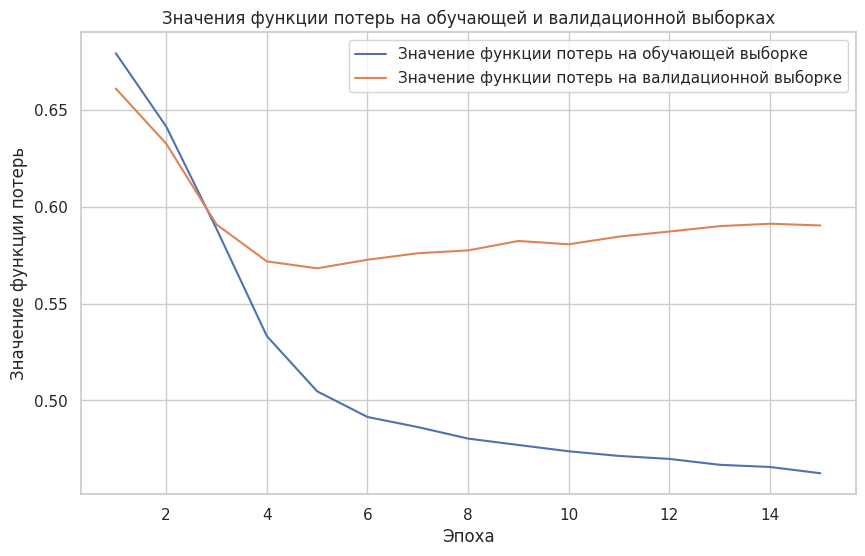

In [65]:
plot_loss_curves(train_losses_lstm_tfidf, val_losses_lstm_tfidf)

### LSTM + Word2Vec

In [66]:
lstm_word2vec, lstm_word2vec_time, train_losses_lstm_word2vec, val_losses_lstm_word2vec = train_and_evaluate_model(train_and_evaluate_lstm, Word2Vec_sets)


Ранняя остановка обучения!
====== Тип использованной токенизации: Word2Vec ======
Время, затраченное на предсказания: 0.0051648617 секунд

F1-score (weighted avg) на валидационной выборке: 0.4525
F1-score (weighted avg) на тестовой выборке: 0.4450

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        87
           1       0.00      0.00      0.00        59

    accuracy                           0.60       146
   macro avg       0.30      0.50      0.37       146
weighted avg       0.36      0.60      0.44       146



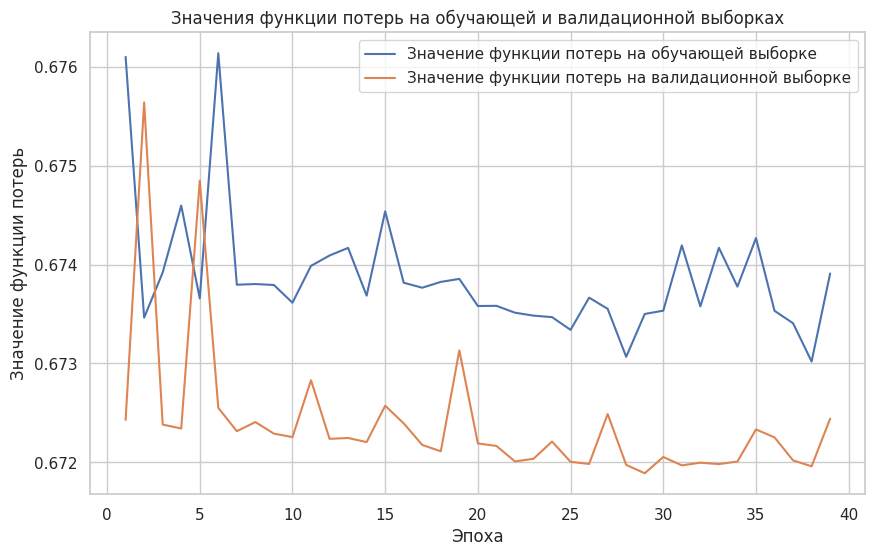

In [67]:
plot_loss_curves(train_losses_lstm_word2vec, val_losses_lstm_word2vec)

### LSTM + FastText

In [68]:
lstm_fasttext, lstm_fasttext_time, train_losses_lstm_fasttext, val_losses_lstm_fasttext = train_and_evaluate_model(train_and_evaluate_lstm, FastText_sets)



Ранняя остановка обучения!
====== Тип использованной токенизации: FastText ======
Время, затраченное на предсказания: 0.0049006939 секунд

F1-score (weighted avg) на валидационной выборке: 0.5164
F1-score (weighted avg) на тестовой выборке: 0.4926

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.60      0.93      0.73        87
           1       0.45      0.08      0.14        59

    accuracy                           0.59       146
   macro avg       0.53      0.51      0.44       146
weighted avg       0.54      0.59      0.49       146



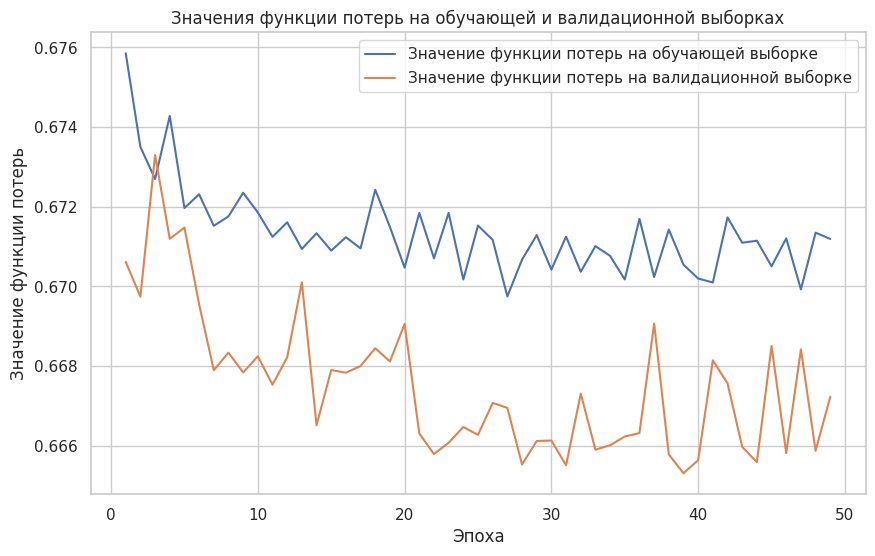

In [69]:
plot_loss_curves(train_losses_lstm_fasttext, val_losses_lstm_fasttext)

### RandomSearch наилучшей модели

In [70]:
import random

In [71]:
# имплементируем случайный поиск
# пространство гиперпараметров 
param_space = {
    # размер скрытого слоя
    "hidden_dim": [32, 64, 128, 256],
    # размер батча
    "batch_size": [16, 32, 64],   
    # скорость обучения
    "lr": [0.1, 0.01, 0.001],
     # количество эпох
    "epochs": [5, 10, 20, 50],
    # параметр для ранней остановки
    "patience": [3, 5, 10]           
}

In [72]:
# функция для подбора наилучших гиперпараметров
def train_and_evaluate_model_with_search(model_function, feature_sets, param_space, num_trials=3):
    X_train, X_val, X_test, y_train, y_val, y_test, feature_name = feature_sets

    best_model = None
    best_val_loss = float('inf')
    best_params = None
    all_train_losses, all_val_losses = None, None
    best_elapsed_time = None

    for trial in range(num_trials):
        # случайным образом выбираем гиперпараметры
        params = {key: random.choice(values) for key, values in param_space.items()}
        print("*******************************************************************")
        print(f"\nПопытка {trial + 1}/{num_trials} с параметрами: {params}")
        
        # обучаем с выбранными гиперпараметрами
        model, el_time, train_losses, val_losses = model_function(
            X_train, X_val, X_test, y_train, y_val, y_test,
            feature_name=feature_name,
            hidden_dim=params["hidden_dim"],
            batch_size=params["batch_size"],
            epochs=params["epochs"],
            patience=params["patience"]
        )
        
        # используем последнее значение функции потерь для выбора модели
        final_val_loss = val_losses[-1]
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = model
            best_params = params
            all_train_losses = train_losses
            all_val_losses = val_losses
            best_elapsed_time = el_time

    print(f"\nМодель с наилучшими параметрами: {best_params}\nЗначение функции потерь: {best_val_loss:.4f}")
    return best_model, best_elapsed_time, all_train_losses, all_val_losses


In [73]:
BEST_lstm_tfidf, BEST_lstm_tfidf_time, BEST_train_losses_lstm_tfidf, BEST_val_losses_lstm_tfidf = train_and_evaluate_model_with_search(
    train_and_evaluate_lstm, TF_IDF_sets, param_space, num_trials=5
)

*******************************************************************

Попытка 1/5 с параметрами: {'hidden_dim': 128, 'batch_size': 32, 'lr': 0.001, 'epochs': 20, 'patience': 5}
Ранняя остановка обучения!
====== Тип использованной токенизации: TF-IDF ======
Время, затраченное на предсказания: 0.0043861866 секунд

F1-score (weighted avg) на валидационной выборке: 0.7377
F1-score (weighted avg) на тестовой выборке: 0.7009

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        87
           1       0.61      0.69      0.65        59

    accuracy                           0.70       146
   macro avg       0.69      0.70      0.69       146
weighted avg       0.71      0.70      0.70       146

*******************************************************************

Попытка 2/5 с параметрами: {'hidden_dim': 256, 'batch_size': 16, 'lr': 0.01, 'epochs': 10, 'patience': 5}
====== Тип использованной токениз

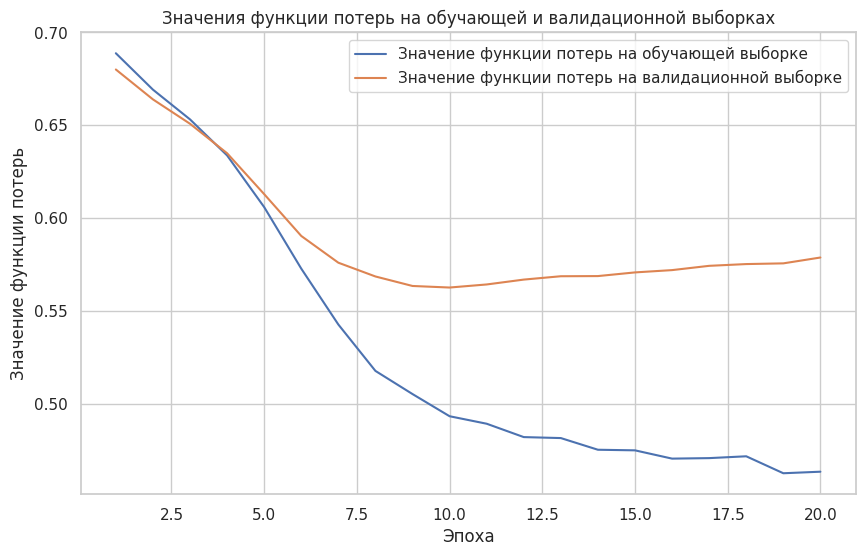

In [74]:
plot_loss_curves(BEST_train_losses_lstm_tfidf, BEST_val_losses_lstm_tfidf)

**Выводы для LSTM**
- Самая плавная функция потерь у TF-IDF
- Результат работы LSTM чуть хуже, чем у случайных деревьев, при этом тратится довольно долгое время на обучение модели

## BERT

Будем использовать модель "cointegrated/rubert-tiny2" - компактную и быструю модель архитектуры BERT

In [75]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

In [76]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
texts = df['combined']
labels = df['polarity'].map({'POS': 1, 'NEG': 0}).values

In [78]:
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [79]:
# кастомный датасет
class CustomDataset(Dataset):
    def __init__(self, reports, labels, tokenizer, max_len=312):
        self.reports = reports
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reports)

    def __getitem__(self, idx):
        res={}
        report = self.reports[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            report,
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,)

        res['input_ids'] = encoding['input_ids'].flatten()
        res['attention_mask'] = encoding['attention_mask'].flatten()
        res['labels']= torch.tensor(label, dtype=torch.long)

        return res

In [80]:
# делим на 3 датасета
train_dataset = CustomDataset(X_train.values, y_train, tokenizer)
val_dataset = CustomDataset(X_val.values, y_val, tokenizer)
test_dataset = CustomDataset(X_test.values, y_test, tokenizer)

In [81]:
# загружаем сплиты в dataloader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [82]:
# перекидываем на gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [83]:
# определяем оптимизатор и ф-ю потерь
# Возможно нужно подкрутить lr и weight_decay
optimizer = AdamW(model.parameters(), lr=2e-6)
loss_fn = nn.CrossEntropyLoss()

In [84]:
# основная часть -- training/eval loops
epochs = 20

train_losses = []
val_losses = []
f1_scores = []

for epoch in range(epochs):
    # обучение
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'train epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    # print(f'train loss: {avg_train_loss}')

    # валидация
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'val epoch {epoch + 1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = loss_fn(logits, labels)
    val_losses.append(val_loss.item())

    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    f1_scores.append(val_f1)

    # print(f'val loss: {val_loss.item()}')
    # print(f'val f1-score: {val_f1}')

val epoch 20/20: 100%|██████████| 55/55 [00:00<00:00, 99.79it/s]


In [85]:
# тест
model.eval()
test_preds = []
test_labels = []

start = time.time()
with torch.no_grad():
    for batch in tqdm(test_loader, desc='testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
end = time.time()
el = end-start

testing: 100%|██████████| 19/19 [00:00<00:00, 99.24it/s]


In [86]:
print(f"F1-score (weighted avg) на тестовой выборке: {f1_score(test_labels, test_preds, average='weighted'):.4f}")
print(f"Время, затраченное на предсказания: {el:.10f} секунд\n")
print(f"Отчёт о классификации (тестовая выборка):\n{classification_report(test_labels,test_preds)}")

F1-score (weighted avg) на тестовой выборке: 0.9038
Время, затраченное на предсказания: 0.1950926781 секунд

Отчёт о классификации (тестовая выборка):
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        87
           1       0.89      0.86      0.88        59

    accuracy                           0.90       146
   macro avg       0.90      0.90      0.90       146
weighted avg       0.90      0.90      0.90       146



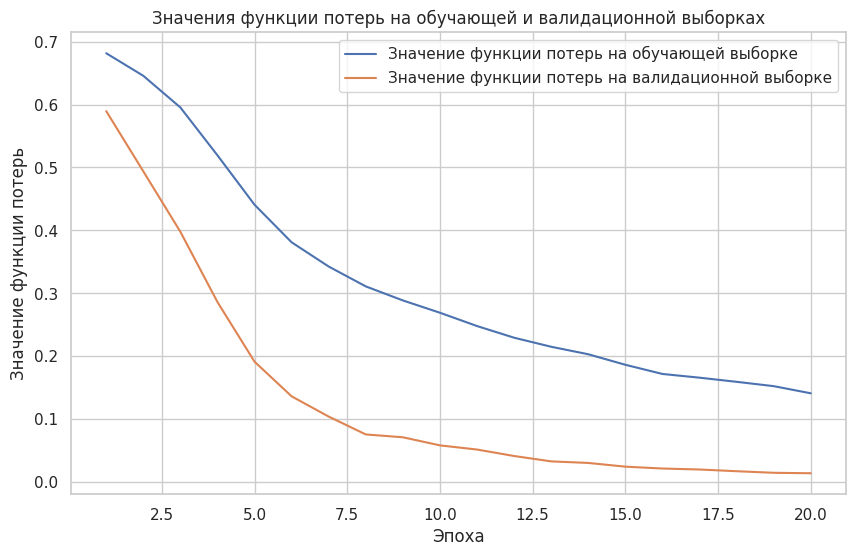

In [87]:
# график функции потерь
plot_loss_curves(train_losses,val_losses)

**Выводы о ruBERT-tiny**
- Модель на 15% превосходит наилучшие результаты других классификаторов "из коробки" (без специальных техник типа early stopping/оптимизации гиперпараметров)
- Затрачивает значительно больше времени на обучение и инференс (но не критично больше)

# Интерпретируемость и результаты

### Анализ интерпретируемости с помощью библиотеки shap

In [88]:
import shap
import numpy as np
import scipy as sp

#### Интерпритация значений ruBERT-tiny

In [89]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding="max_length", max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1]) 
    return val

explainer = shap.Explainer(f, tokenizer)

In [90]:
shap_values = explainer(X_test, fixed_context=1)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
PartitionExplainer explainer: 147it [00:30,  3.55it/s]                         


In [91]:
df.iloc[309:310,:]

,index,text,opinion,source,target,expression,polarity,combined
309,503,В 1979 году Рокфеллер оказался замешан в между...,"{'Source': [['NULL'], ['0:0']], 'Target': [['Р...",NaN,Рокфеллер,предпосылок кризиса с захватом заложников в Иране,NEG,В 1979 году Рокфеллер оказался замешан в между...


In [92]:
shap.plots.text(shap_values[0])

In [93]:
df.iloc[1213:1214,:]

,index,text,opinion,source,target,expression,polarity,combined
1213,1855,Однако спасти бывшего президента не смогли.,"{'Source': [['NULL'], ['0:0']], 'Target': [['п...",NaN,президента,спасти,POS,Однако спасти бывшего президента не смогли.|сп...


In [94]:
shap.plots.text(shap_values[1])

Можем видеть, что слова, положительно влияющие на класс "POS" (такие как "помог", "спасти") также соотносятся с концепциями "положительного" в естественном языке.<br>
Слова, отрицательно влияющие на определение положительной тональности имеют, например, ярко выраженные политические ассоциации ("кризис", "Иран" и т.д.)

In [96]:
TF_IDF_X_train_explanation_set = TF_IDF_sets[0]
TF_IDF_X_test_explanation_set = TF_IDF_sets[2]